In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import expon
from scipy.stats import norm
from scipy import stats

from collections import Counter

from math import radians, cos, sin, asin, sqrt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

In [3]:
# df = pd.read_csv('最终干净的数据.csv')
path = 'C:\\Users\\ASUS\\Desktop\\IOM魔改2\\IOM209\\最终干净的数据改.csv'
try:
    # 将 low_memory 设置为 False
    df = pd.read_csv(path, low_memory=False)
    print("文件读取成功")
except FileNotFoundError:
    print("文件未找到，请检查文件路径。")
except Exception as e:
    print(f"发生其他错误: {e}")

文件读取成功


In [4]:
selected_features = [
    'tradeTime', 'followers', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
    'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition', 
    'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 
    'subway', 'district', 'communityAverage', 'distance', 'Age', 
    'floorType', 'floorHeight', 'room_count', 'room_ratio','north_south','Investment in residential real estate development in Beijing'
]

In [5]:
X = df[selected_features]      # 特征列
y = df['price_log']            # 回归目标：对数价格

In [6]:
#数据集划分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
#开始xgb

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings

In [8]:
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
y_pred = model.predict(X_test)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
r2_log = r2_score(y_test, y_pred)

print("XGBoost - Log Space:")
print(f"R²: {r2_log:.4f}")
print(f"RMSE: {rmse_log:.4f}")
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print("\n XGBoost - Original Price :")
print(f"RMSE (RMB/㎡): {rmse_original:.2f}")

XGBoost - Log Space:
R²: 0.9018
RMSE: 0.1392

 XGBoost - Original Price :
RMSE (RMB/㎡): 5972.80


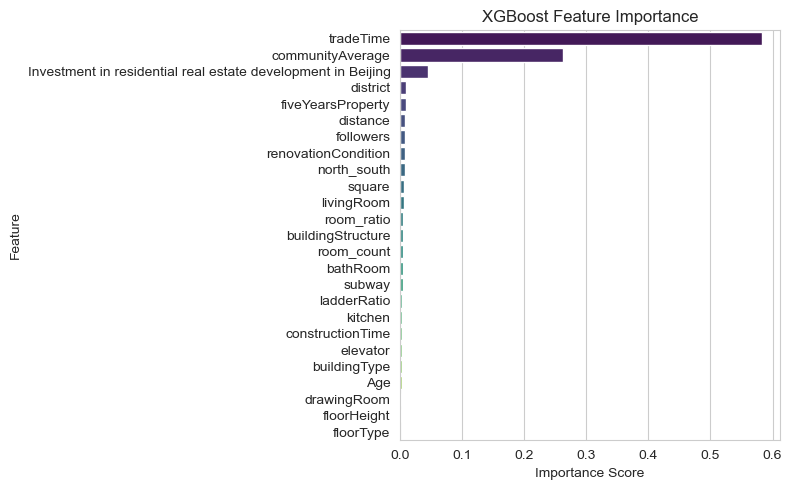

In [10]:
# 特征重要性
xgb_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

# 可视化
plt.figure(figsize=(8, 5))
sns.barplot(data=xgb_importance, x="importance", y="feature", palette="viridis")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

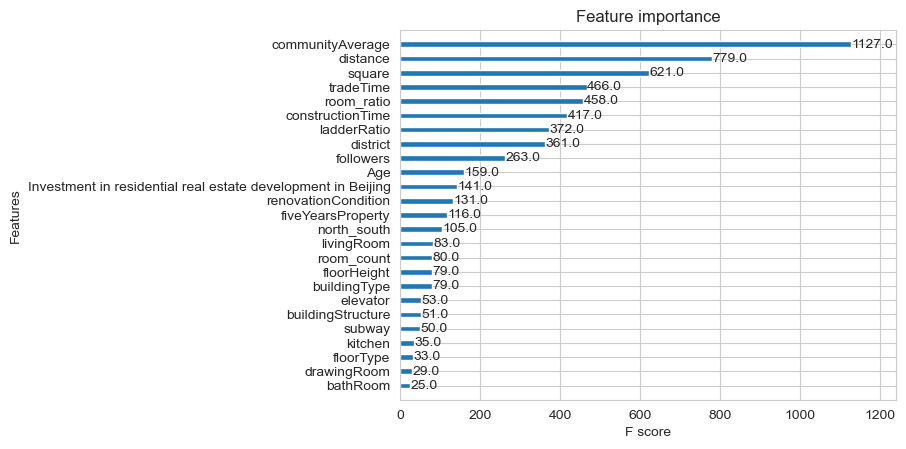

In [11]:
from xgboost import plot_importance
plot_importance(model, height=0.4, importance_type='weight')  # 'gain' 或 'cover' 也可，反正就是三种不同的调参
plt.show()

In [12]:
#害怕过拟合
# 1. 训练集 R²
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"Training Set R²: {r2_train:.4f}")

Training Set R²: 0.9055


In [13]:
# 2. 交叉验证
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross Validation R² Average Value: {cv_scores.mean():.4f}")

Cross Validation R² Average Value: 0.7525


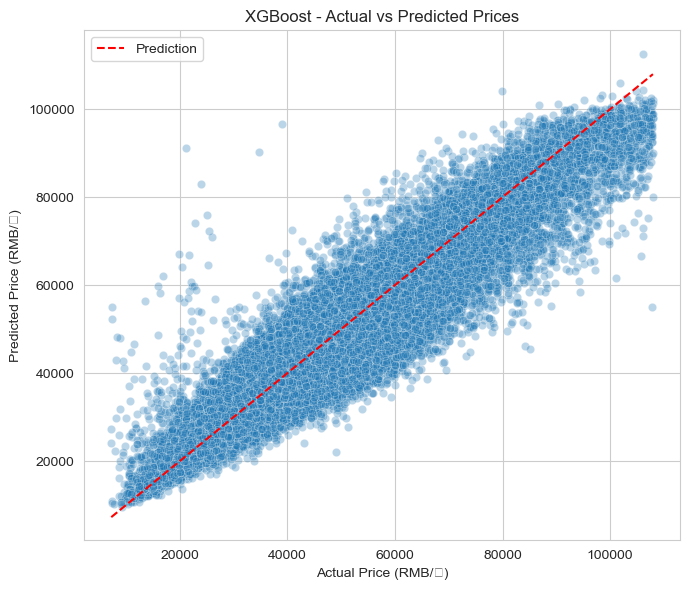

In [14]:
# 反转换预测和真实值回原始价格单位
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# 绘制散点图
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--',label='Prediction')
plt.xlabel('Actual Price (RMB/㎡)')
plt.ylabel('Predicted Price (RMB/㎡)')
plt.title('XGBoost - Actual vs Predicted Prices')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
#使用GridSearchCV 自动调参 XGBoost

In [15]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 设置超参数搜索空间
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 初始化模型
xgb_base = XGBRegressor(random_state=42)

# GridSearchCV对象
grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 执行网格搜索
grid.fit(X_train, y_train)

print("Best R² score:", grid.best_score_)
print("Best parameters:", grid.best_params_)

# 获取最佳模型对应的索引
best_index = grid.best_index_

# 查看最优参数下每次交叉验证折的 R² 分数
for i in range(5):
    split_score = grid.cv_results_[f'split{i}_test_score'][best_index]
    print(f"Fold {i + 1} R² score: {split_score}")

# 输出最佳参数和分数
print("Best R² score:", grid.best_score_)
print("Best parameters:", grid.best_params_)

# 使用最优模型预测
best_xgb = grid.best_estimator_
y_pred_grid = best_xgb.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best R² score: 0.9110066591939425
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Fold 1 R² score: 0.9112548004300834
Fold 2 R² score: 0.9102003119074198
Fold 3 R² score: 0.9114804877481433
Fold 4 R² score: 0.9111643492606719
Fold 5 R² score: 0.910933346623394
Best R² score: 0.9110066591939425
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}


In [19]:
best_params = grid.best_params_
print("Best parameters:", best_params)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}


In [16]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
print(f"Cross Validation R² Average Value: {cv_scores.mean():.4f}")

Cross Validation R² Average Value: 0.7537


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# 自定义RMSE评分指标
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

# 进行R²交叉验证
r2_cv_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
# 进行RMSE交叉验证
rmse_cv_scores = cross_val_score(best_xgb, X, y, cv=5, scoring=rmse_scorer)

# 输出交叉验证的R²平均值
print(f"Cross Validation R² Average Value: {r2_cv_scores.mean():.4f}")
# 输出交叉验证的RMSE平均值
print(f"Cross Validation RMSE Average Value: {rmse_cv_scores.mean():.4f}")

Cross Validation R² Average Value: 0.7537
Cross Validation RMSE Average Value: 0.1784


In [19]:
# Fitting 5 folds for each of 48 candidates, totalling 240 fits
# Best R² score: 0.9105885621856931
# Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

In [23]:
# 评估 log 空间
r2_best = r2_score(y_test, y_pred_grid)
rmse_best_log = np.sqrt(mean_squared_error(y_test, y_pred_grid))

# 还原价格
y_pred_grid_original = np.expm1(y_pred_grid)
y_test_original = np.expm1(y_test)
rmse_best_original = np.sqrt(mean_squared_error(y_test_original, y_pred_grid_original))

print(f"Best XGBoost R²: {r2_best:.4f}")
print(f"Best XGBoost RMSE (log): {rmse_best_log:.4f}")
print(f"Best XGBoost RMSE (original): {rmse_best_original:.2f} RMB/m²")

Best XGBoost R²: 0.9126
Best XGBoost RMSE (log): 0.1313
Best XGBoost RMSE (original): 5663.88 RMB/m²


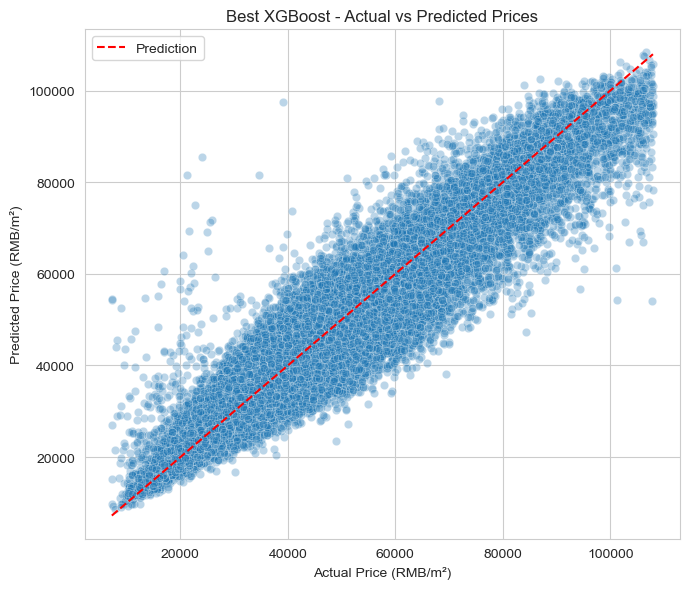

In [24]:
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_original, y=y_pred_grid_original, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', label='Prediction')

plt.xlabel('Actual Price (RMB/m²)')
plt.ylabel('Predicted Price (RMB/m²)')
plt.title('Best XGBoost - Actual vs Predicted Prices')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
#在使用GridSearchCV 自动调参 XGBoost后，继续使用EarlyStopping，避免过拟合

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 拟合模型 + 提前停止
xgb_es = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=1000,
    subsample=0.8,
    early_stopping_rounds=20,
    eval_metric="rmse", 
    random_state=42
)

# fit 时加上验证集
xgb_es.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], 
    verbose=False
)

# 预测 + 评估
y_pred_es = xgb_es.predict(X_test)
r2_es = r2_score(y_test, y_pred_es)
rmse_es_log = np.sqrt(mean_squared_error(y_test, y_pred_es))

# 反变换
y_pred_es_original = np.expm1(y_pred_es)
y_test_original = np.expm1(y_test)
rmse_es_original = np.sqrt(mean_squared_error(y_test_original, y_pred_es_original))

# 输出
print(f"XGBoost (EarlyStopping) R²: {r2_es:.4f}")
print(f"RMSE (log): {rmse_es_log:.4f}")
print(f"RMSE (original): {rmse_es_original:.2f} RMB/m²")

XGBoost (EarlyStopping) R²: 0.9156
RMSE (log): 0.1291
RMSE (original): 5574.26 RMB/m²


In [33]:
print("Best iteration (tree index):", xgb_es.best_iteration)

Best iteration (tree index): 681
